# Amazon Fine Food Review With GBDT

### We will be using GBDT Classifier to evaluate Two Hyperparameter as Estimator and Learning rate

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import string
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
from sklearn import datasets, neighbors
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
import graphviz
import os
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import RandomizedSearchCV
import seaborn as sns

C:\Users\Soni\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Soni\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\Soni\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
conn = sqlite3.connect('final.sqlite')#Loading the Data set
final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)

In [4]:
final = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')#Sorting the data according to the Time in ascending order

In [5]:
x = final['CleanedText'].values[0:100000]#Taking 100K Values 
y = final['Score'].values[0:100000]

In [6]:
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
5,1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,None
4,1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,None
284,28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe...",None
285,28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1,1067040000,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...,None
545,38740,42069,B0000EIEQU,A1YMJX4YWCE6P4,"Jim Carson ""http://www.jimcarson.com""",12,12,1,1067558400,These limes rule!,"Fresh limes are underappreciated, but a joy to...",None


In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.3, random_state=42)#Splitting the data into Test and Train

In [6]:
#Plot Confusion Matrix for the dataset
from sklearn.metrics import confusion_matrix
import itertools   
def plot_confusion_matrix(cm, classes,
      
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
     #else:
      #  print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2g' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [7]:
def important_features(vectorizer,classifier,n):
    class_labels = classifier.classes_
    feature_names =vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.feature_importances_, feature_names),reverse=True)
    print("Important features in Decision Tree")
    for coef, feat in topn_class1[:n]:
        print(feat)

# BOW

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(min_df = 10) #Vectorization for BOW
X_train = count_vect.fit_transform(x_train)# Fitting and training our dataset on train dataset
X_test = count_vect.transform(x_test)
print("Train Data Size: ",X_train.shape)
print("Test Data Size: ",X_test.shape)


Train Data Size:  (70000, 7160)
Test Data Size:  (30000, 7160)


In [9]:
base_lerner=[5, 10, 50, 100, 200, 500, 1000]
max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]
hyperparam={'n_estimators':base_lerner, 'max_depth':max_depth}
clf=GradientBoostingClassifier()
clf=GridSearchCV(clf, hyperparam, cv=2, n_jobs=-1, verbose=1)
clf.fit(X_train,y_train)
base=clf.best_estimator_.get_params()['n_estimators']
maxd=clf.best_estimator_.get_params()['max_depth']
print('optimal n_estimators = ',base)
print('optimal max_depth = ',maxd)


Fitting 2 folds for each of 63 candidates, totalling 126 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed: 97.7min finished


optimal n_estimators =  1000
optimal max_depth =  7


In [11]:
gbdt_optimal_bow = GradientBoostingClassifier(max_depth= 7, n_estimators=1000)
# fitting the model
gbdt_optimal_bow.fit(X_train, y_train)
# predict the response
pred = gbdt_optimal_bow.predict(X_test)
# evaluate accuracy
acc_bow = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the Gradient Boosting decision tree classifier for max_depth = %d is %f%%' % (7, acc_bow))

print('\nThe accuracy of the Gradient Boosting decision tree classifier for n_estimators = %d is %f%%' % (1000, acc_bow))

print('\nThe error of the Gradient Boosting decision tree classifier for max_depth = %d is %f%%' % (7,100-acc_bow))

print('\nThe error of the Gradient Boosting decision tree classifier for n_estimators = %d is %f%%' % (100,100-acc_bow))


The accuracy of the Gradient Boosting decision tree classifier for max_depth = 7 is 92.300000%

The accuracy of the Gradient Boosting decision tree classifier for n_estimators = 1000 is 92.300000%

The error of the Gradient Boosting decision tree classifier for max_depth = 7 is 7.700000%

The error of the Gradient Boosting decision tree classifier for n_estimators = 100 is 7.700000%


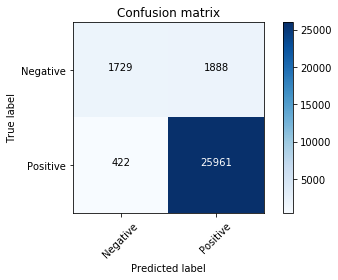

In [12]:
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=["Negative","Positive"])

# Heat Map with Two Hyperparameters

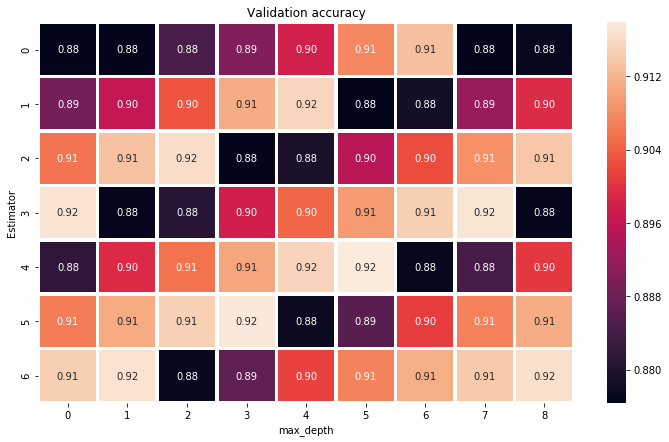

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 7))
scores = clf.cv_results_['mean_test_score'].reshape(len(base_lerner),len(max_depth))
sns.heatmap(scores, annot=True, fmt=".2f" , linewidths=2.5)

plt.xlabel('max_depth')
plt.ylabel('Estimator')
plt.title('Validation accuracy')
plt.show()


In [14]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, pred, average='weighted')#Generating Values for Precision,Recall and Fscore

(0.9167258306021353, 0.923, 0.9142555382341526, None)

In [15]:
test = gbdt_optimal_bow.feature_importances_

In [16]:
imp = test.argsort()

In [17]:
wc = np.take(count_vect.get_feature_names(),imp[1:50])

In [18]:
s1= str(wc)

# Important Features in Word Cloud

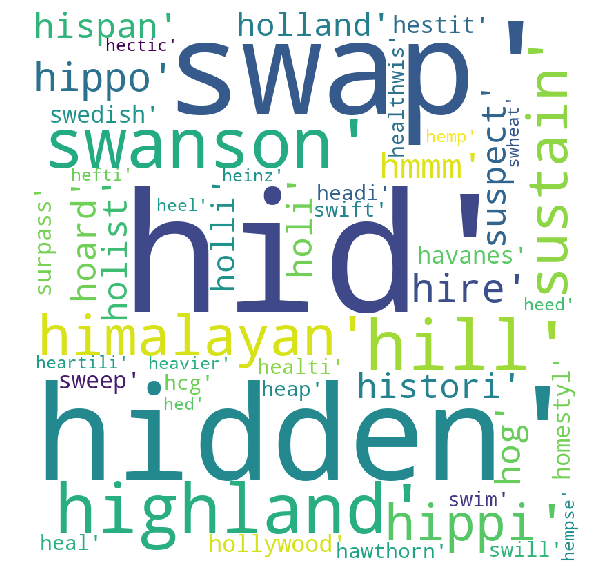

In [19]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(s1) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

# TFIDF

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)#Vectorizering the data
X_train_tfidf = tf_idf_vect.fit_transform(x_train)
X_test_tfidf = tf_idf_vect.transform(x_test)
print("the type of count vectorizer ",type(X_train_tfidf))
print("Train Data Size: ",X_train_tfidf.shape)
print("Test Data Size: ",X_test_tfidf.shape)


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
Train Data Size:  (70000, 40557)
Test Data Size:  (30000, 40557)


In [21]:
base_lerner=[5, 10, 50, 100, 200, 500, 1000]
max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]
hyperparam={'n_estimators':base_lerner, 'max_depth':max_depth}
clf0=GradientBoostingClassifier()
clf0=GridSearchCV(clf0, hyperparam, cv=2, n_jobs=-1, verbose=1)
clf0.fit(X_train_tfidf,y_train)
base=clf0.best_estimator_.get_params()['n_estimators']
maxd=clf0.best_estimator_.get_params()['max_depth']
print('optimal n_estimators = ',base)
print('optimal max_depth = ',maxd)


Fitting 2 folds for each of 63 candidates, totalling 126 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 43.1min
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed: 301.8min finished


optimal n_estimators =  1000
optimal max_depth =  4


In [22]:
gbdt_optimal_tfidf = GradientBoostingClassifier(max_depth= 4, n_estimators=1000)
# fitting the model
gbdt_optimal_tfidf.fit(X_train_tfidf, y_train)
# predict the response
pred_tfidf = gbdt_optimal_tfidf.predict(X_test_tfidf)
# evaluate accuracy
acc_tfidf = accuracy_score(y_test, pred_tfidf) * 100
print('\nThe accuracy of the Gradient Boosting decision tree classifier for max_depth = %d is %f%%' % (4, acc_tfidf))

print('\nThe accuracy of the Gradient Boosting decision tree classifier for n_estimators = %d is %f%%' % (1000, acc_tfidf))

print('\nThe error of the Gradient Boosting decision tree classifier for max_depth = %d is %f%%' % (4,100-acc_tfidf))

print('\nThe error of the Gradient Boosting decision tree classifier for n_estimators = %d is %f%%' % (1000,100-acc_tfidf))


The accuracy of the Gradient Boosting decision tree classifier for max_depth = 4 is 92.156667%

The accuracy of the Gradient Boosting decision tree classifier for n_estimators = 1000 is 92.156667%

The error of the Gradient Boosting decision tree classifier for max_depth = 4 is 7.843333%

The error of the Gradient Boosting decision tree classifier for n_estimators = 1000 is 7.843333%


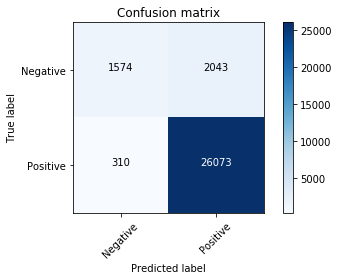

In [23]:
plot_confusion_matrix(confusion_matrix(y_test, pred_tfidf), classes=["Negative","Positive"])

In [24]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, pred_tfidf, average='weighted')#Generating Values for Precision,Recall and Fscore

(0.9162590496106666, 0.9215666666666666, 0.9104591387246982, None)

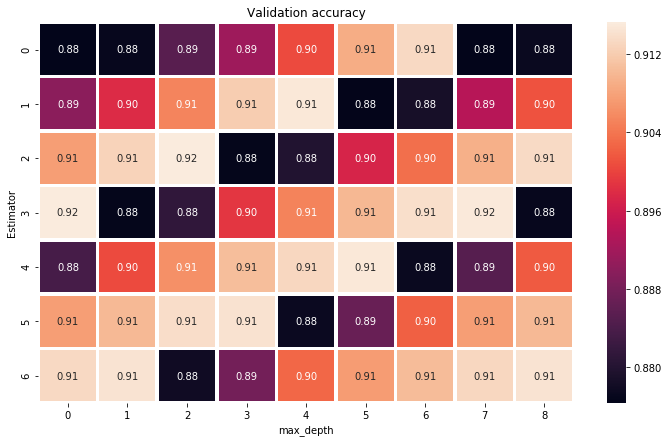

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 7))
scores = clf0.cv_results_['mean_test_score'].reshape(len(base_lerner),len(max_depth))
sns.heatmap(scores, annot=True, fmt=".2f" , linewidths=2.5)

plt.xlabel('max_depth')
plt.ylabel('Estimator')
plt.title('Validation accuracy')
plt.show()


In [26]:
important_features(tf_idf_vect,gbdt_optimal_tfidf,20)


Important features in Decision Tree
good
great
tast
love
disappoint
product
best
worst
would
flavor
buy
terribl
stale
aw
like
get
mayb
bad
much
two star


In [27]:
test1 = gbdt_optimal_tfidf.feature_importances_
imp1 = test1.argsort()
wc1 = np.take(tf_idf_vect.get_feature_names(),imp[1:50])
s2= str(wc1)

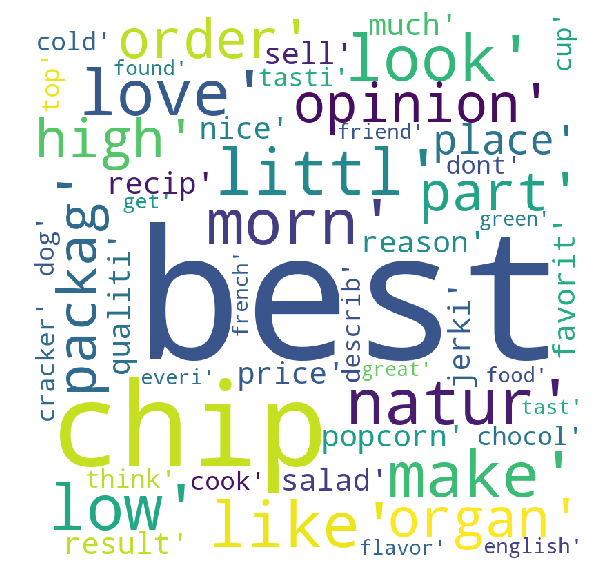

In [28]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(s2) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

# AVG W2V

In [29]:
#Word 2 Vector for train corpus
list_of_sent_train=[]#Stored in a list
for sent in x_train:
    list_of_sent_train.append(sent.split())
    
w2v_model_train=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=4)
print(w2v_model_train)

w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

Word2Vec(vocab=10698, size=50, alpha=0.025)
number of words that occured minimum 5 times  10698
sample words  ['decid', 'roll', 'dice', 'bought', 'spring', 'onion', 'split', 'pea', 'soup', 'sinc', 'like', 'drink', 'wasnt', 'disappoint', 'littl', 'scare', 'first', 'time', 'order', 'food', 'type', 'item', 'amazon', 'sister', 'thought', 'crazi', 'someth', 'normal', 'dont', 'far', 'favorit', 'tri', 'bland', 'tast', 'compar', 'ambrosia', 'tomorrow', 'season', 'perfect', 'light', 'good', 'expect', 'come', 'cup', 'noodl', 'best', 'microwav', 'ever', 'know', 'might']


In [30]:
#Word 2 Vector for test corpus
list_of_sent_test=[]
for sent in x_test:
    list_of_sent_test.append(sent.split())
    
w2v_model_test=Word2Vec(list_of_sent_test,min_count=5,size=50, workers=4)
print(w2v_model_test)

w2v_words_test = list(w2v_model_test.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_test))
print("sample words ", w2v_words_test[0:50])

Word2Vec(vocab=7458, size=50, alpha=0.025)
number of words that occured minimum 5 times  7458
sample words  ['like', 'organ', 'whole', 'grain', 'brown', 'rice', 'take', 'look', 'label', 'milk', 'product', 'two', 'thing', 'dont', 'often', 'see', 'find', 'togeth', 'one', 'made', 'favorit', 'far', 'three', 'boy', 'love', 'even', 'mix', 'unsweeten', 'soy', 'cut', 'sugar', 'high', 'recommend', 'anyon', 'want', 'need', 'avoid', 'dairi', 'that', 'posit', 'say', 'arent', 'lot', 'choic', 'decaf', 'tassimo', 'moment', 'make', 'brew', 'cup']


In [31]:
#train corpus
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            #print(word)
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

70000
50


In [32]:
#test Corpus
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
    
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

30000
50


In [33]:
base_lerner=[5, 10, 50, 100, 200, 500, 1000]
max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]
hyperparam={'n_estimators':base_lerner, 'max_depth':max_depth}
clf1=GradientBoostingClassifier()
clf1=GridSearchCV(clf1, hyperparam, cv=2, n_jobs=-1, verbose=1)
clf1.fit(sent_vectors_train,y_train)
base=clf1.best_estimator_.get_params()['n_estimators']
maxd=clf1.best_estimator_.get_params()['max_depth']
print('optimal n_estimators = ',base)
print('optimal learning rate = ',maxd)


Fitting 2 folds for each of 63 candidates, totalling 126 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed: 233.2min finished


optimal n_estimators =  1000
optimal learning rate =  9


In [34]:
gbdt_optimal_w2v = GradientBoostingClassifier(max_depth= 9, n_estimators=1000)
# fitting the model
gbdt_optimal_w2v.fit(sent_vectors_train, y_train)
# predict the response
pred_w2v = gbdt_optimal_w2v.predict(sent_vectors_test)
# evaluate accuracy
acc_w2v = accuracy_score(y_test, pred_w2v) * 100
print('\nThe accuracy of the Gradient Boosting decision tree classifier for max_depth = %d is %f%%' % (9, acc_w2v))

print('\nThe accuracy of the Gradient Boosting decision tree classifier for n_estimators = %d is %f%%' % (1000, acc_w2v))

print('\nThe error of the Gradient Boosting decision tree classifier for max_depth = %d is %f%%' % (9,100-acc_w2v))

print('\nThe error of the Gradient Boosting decision tree classifier for n_estimators = %d is %f%%' % (1000,100-acc_w2v))


The accuracy of the Gradient Boosting decision tree classifier for max_depth = 9 is 90.986667%

The accuracy of the Gradient Boosting decision tree classifier for n_estimators = 1000 is 90.986667%

The error of the Gradient Boosting decision tree classifier for max_depth = 9 is 9.013333%

The error of the Gradient Boosting decision tree classifier for n_estimators = 1000 is 9.013333%


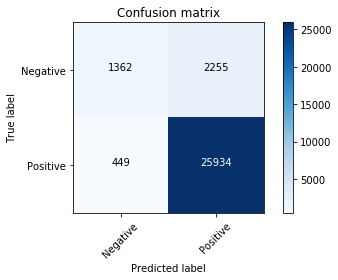

In [35]:
plot_confusion_matrix(confusion_matrix(y_test, pred_w2v), classes=["Negative","Positive"])

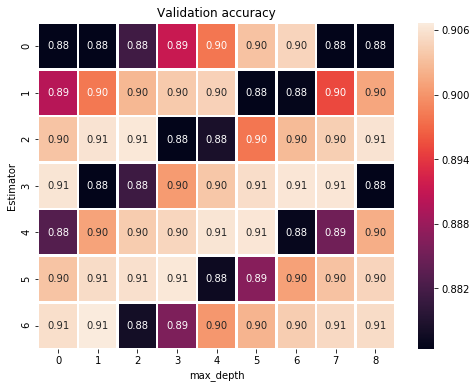

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
scores = clf1.cv_results_['mean_test_score'].reshape(len(base_lerner),len(max_depth))
sns.heatmap(scores, annot=True, fmt=".2f" , linewidths=1.5)

plt.xlabel('max_depth')
plt.ylabel('Estimator')
plt.title('Validation accuracy')
plt.show()


In [37]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, pred_w2v, average='weighted')#Generating Values for Precision,Recall and Fscore

(0.8997570652832932, 0.9098666666666667, 0.8963635513756024, None)

# TFIDF W2V

In [38]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [39]:
tfidf_feat = tf_idf_vect.get_feature_names()#getting feature list

In [40]:
from tqdm import tqdm
tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))#taking the dictionary to train words to plt vector. 
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [01:37<00:00, 714.31it/s]


70000
50


In [41]:
model = TfidfVectorizer(ngram_range=(1,2))
tf_idf_matrix = model.fit_transform(x_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_test = dict(zip(model.get_feature_names(), list(model.idf_)))

In [42]:
#test corpus
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_test[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [00:43<00:00, 688.92it/s]


30000
50


In [43]:
base_lerner=[5, 10, 50, 100, 200, 500, 1000]
max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]
hyperparam={'n_estimators':base_lerner, 'max_depth':max_depth}
clf2=GradientBoostingClassifier()
clf2=GridSearchCV(clf2, hyperparam, cv=2, n_jobs=-1, verbose=1)
clf2.fit(tfidf_sent_vectors_train,y_train)
base=clf2.best_estimator_.get_params()['n_estimators']
maxd=clf2.best_estimator_.get_params()['max_depth']
print('optimal n_estimators = ',base)
print('optimal max_depth = ',maxd)


Fitting 2 folds for each of 63 candidates, totalling 126 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 24.5min
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed: 228.2min finished


optimal n_estimators =  1000
optimal max_depth =  7


In [44]:
gbdt_optimal_tfidfw2v = GradientBoostingClassifier(max_depth= 7, n_estimators=1000)
# fitting the model
gbdt_optimal_tfidfw2v.fit(tfidf_sent_vectors_train, y_train)
# predict the response
pred_tfidfw2v = gbdt_optimal_tfidfw2v.predict(tfidf_sent_vectors_test)
# evaluate accuracy
acc_tfidfw2v = accuracy_score(y_test, pred_tfidfw2v) * 100
print('\nThe accuracy of the Gradient Boosting decision tree classifier for max_depth = %d is %f%%' % (7, acc_tfidfw2v))

print('\nThe accuracy of the Gradient Boosting decision tree classifier for n_estimators = %d is %f%%' % (1000, acc_tfidfw2v))

print('\nThe error of the Gradient Boosting decision tree classifier for max_depth = %d is %f%%' % (7,100-acc_tfidfw2v))

print('\nThe error of the Gradient Boosting decision tree classifier for n_estimators = %d is %f%%' % (1000,100-acc_tfidfw2v))


The accuracy of the Gradient Boosting decision tree classifier for max_depth = 7 is 90.196667%

The accuracy of the Gradient Boosting decision tree classifier for n_estimators = 1000 is 90.196667%

The error of the Gradient Boosting decision tree classifier for max_depth = 7 is 9.803333%

The error of the Gradient Boosting decision tree classifier for n_estimators = 1000 is 9.803333%


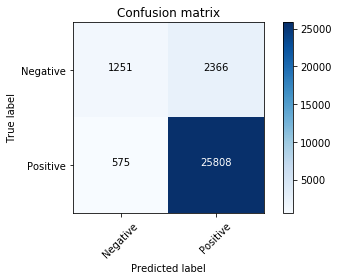

In [45]:
plot_confusion_matrix(confusion_matrix(y_test, pred_tfidfw2v), classes=["Negative","Positive"])

In [46]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, pred_tfidfw2v, average='weighted')#Generating Values for Precision,Recall and Fscore

(0.8881808733167665, 0.9019666666666667, 0.8874470266069591, None)

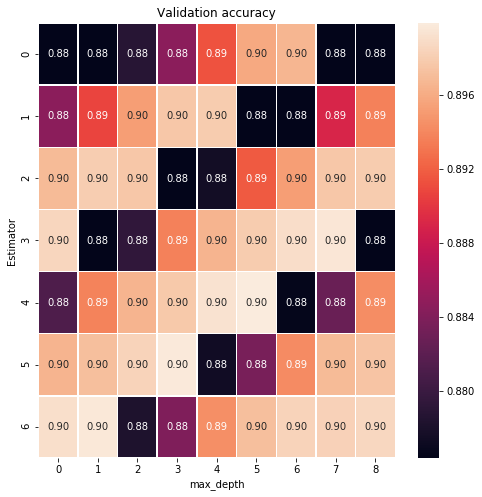

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
scores = clf2.cv_results_['mean_test_score'].reshape(len(base_lerner),len(max_depth))
sns.heatmap(scores, annot=True, fmt=".2f" , linewidths=0.5)

plt.xlabel('max_depth')
plt.ylabel('Estimator')
plt.title('Validation accuracy')
plt.show()


| Vector |  N_Estimator | Max Depth |  Accuracy  | Error 
|------------|--------|
|   BOW     |  1000  | 7 | 92.30 | 7.70
|   TFIDF   |  1000 | 4 | 92.15 | 7.84 
|   AVGW2VEC    | 1000   | 9 | 90.98 | 9.01
|  TFIDF AVGW2VEC   |  1000 | 7 | 90.19 | 9.80 

# AVG W2V is the best model 